# Engineering Transparency into Your Multinomial Machine Learning Model with Python

### Multinomial partial dependence, ICE, and Shapley explanations
In this notebook a gradient boosting machine (GBM) is trained to predict the credit card repayment status's in the month of September 2005, using the UCI credit card default data, Python, NumPy, Pandas, and XGBoost. First, the credit card data is loaded and prepared. Then the multinomial model is trained. After the model is trained, partial dependence and individual conditional expectation (ICE) plots are used to analyze and verify the model's behavior. Finally an example of creating regulator mandated reason codes from high fidelity Shapley explanations for any model prediction is presented. This combination of partial dependence, ICE, and Shapley explanations is probably the most direct way to create an interpretable machine learning model today.

In addition to above, `eli5` and `LIME` variable importances are also presented globally and locally for comparision purposes.

### Python imports

In [1]:
import sys
sys.path.append("../..") 

import numpy as np                   
import pandas as pd                 
import xgboost as xgb                
import shap
import eli5
import h2o
import os

from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from lime_explainer import LIMEExplainer

import matplotlib.pyplot as plt
pd.options.display.max_columns = 999

%matplotlib inline

np.random.seed(12345)

cwd = os.getcwd()
print("Current working directory is " + cwd)

Current working directory is /Users/navdeepgill/Desktop/git/interpretable-ml/notebooks/credit/multinomial


In [2]:
h2o.init(max_mem_size='12G')
h2o.remove_all()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,35 mins 47 secs
H2O cluster timezone:,America/Los_Angeles
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,24 days
H2O cluster name:,H2O_from_python_navdeepgill_wun0ve
H2O cluster total nodes:,1
H2O cluster free memory:,10.37 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"locked, healthy"


# Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 24 variables. We will use the following as inputs to our multinomial model: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_2` - `PAY_6`**: History of past payment; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT2` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

The above 21 input variables are used to predict the target variable, the payment status in Sept 2005 (`PAY_0`). Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data.

In [3]:
#Import XLS file
path = '../data/default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

### Assign modeling roles

The shorthand name `y` is assigned to the prediction target, `PAY_0`. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`, the typical outcome for a binary case, `default payment next month`, and `PAY_AMT1`, which is a variable that contains payment information about Sept, 2005 which we would normally NOT know given the outcome, `PAY_0` (payment status in Sept 2005).

In [4]:
#Assign target and inputs for GBM
y = 'PAY_0'
X = [name for name in data.columns if name not in [y, 'ID','default payment next month', 'PAY_AMT1']]
print('y =', y)
print('X =', X)

y = PAY_0
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


In [5]:
#Convert PAY_0 to be 0-num_classes as XGBoost expects a multinomial outcome to have a min value of 0
for i in range(0, data.shape[0]):
    if data["PAY_0"][i] < 0:
        data["PAY_0"][i] = 0

### Description of target column, `PAY_0`
* 0: `no consumption, pay duly, use of revolving credit`
* 1: `1 month delay` 
* 2: `2 month delay`
* 3: `3 month delay`
* 4: `4 month delay` 
* 5: `5 month delay` 
* 6: `6 month delay` 
* 7: `7 month delay` 
* 8: `8 month delay`

### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `LIMIT_BAL`, `SEX`, `EDUCATION`, `MARRIAGE`, `AGE`, `PAY_2`-`PAY_6`, `BILL_AMT1`-`BILL_AMT6`, `PAY_AMT2`-`PAY_AMT6` and the prediction target `PAY_0`. `PAY_2`-`PAY_6` & `PAY_0` are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [6]:
data[X + [y]].describe() #Display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,PAY_0
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.356767
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.760594
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,8.000000


# Train multinomial XGBoost model

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, global Shapley variable importance is calculated and displayed. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

### Split data into training and test sets for early stopping

The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [7]:
np.random.seed(12345) #Set random seed for reproducibility
split_ratio = 0.7     #70%/30% train/test split

#Execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

#Summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


### Train XGBoost GBM multinomial classifier
To train an XGBoost multinomial classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. 

Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test multiclass logloss fails to decrease for 50 iterations.

In [8]:
dtrain = xgb.DMatrix(train[X], label=train[y])
dtest = xgb.DMatrix(test[X], label=test[y])

#Tuning parameters
params = {
    'objective': 'multi:softprob',              #Multinomial classification
    'booster': 'gbtree',                        #Base learner will be decision tree
    'eval_metric': 'mlogloss',                  #Stop training based on multinomial logloss
    'eta': 0.01,                                #Learning rate
    'subsample': 0.9,                           #Use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    #Use 90% of columns in each decision tree
    'max_depth': 6,                             #Allow decision trees to grow to depth of 6
    'seed': 12345,                              #Set random seed for reproducibility
    'num_class': 9,
    'silent': 1
}

#Watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

#Train model
xgb_model = xgb.train(params,                   #Set tuning parameters from above                   
                      dtrain,                   #Training data
                      1000,                     #Maximum of 1000 iterations (trees)
                      evals=watchlist,          #Use watchlist for early stopping 
                      early_stopping_rounds=50, #Stop after 50 iterations (trees) without decrease in mlogloss
                      verbose_eval=False)       #Display iteration progress or not


### Global Shapley Variable Importance using TreeExplainer

In [9]:
shap_values_tree_explainer = shap.TreeExplainer(xgb_model).shap_values(dtest)

### Display TreeExplainer global Shapley variable importance summary
A good way to look at multinomial Shapley variable importance involves getting the mean absolute Shapley value broken down per class in the same plot

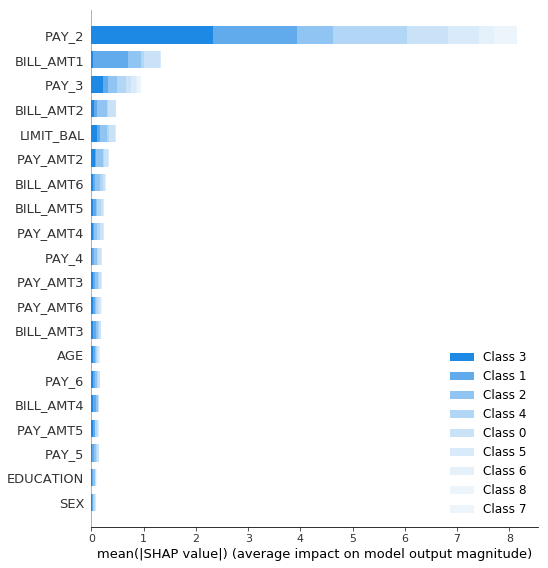

In [10]:
#Plot Shapley values broken down per class
plt.title("Global Shapley Variable Importance")
shap.summary_plot(shap_values_tree_explainer, test[xgb_model.feature_names], show=False)
plt.savefig('./images/global_shapley_per_class.png',bbox_inches='tight')
plt.close()

#To show in notebook
shap.summary_plot(shap_values_tree_explainer, test[xgb_model.feature_names])

### XGBoost global Shapley variable importance
By setting pred_contribs=True, XGBoost's predict() function will return Shapley values for each row and for each class of the test set. Instead of relying on traditional single-value variable importance measures, local Shapley values for each input will be plotted below to get a more holistic and consisent measurement for the global importance of each input variable.

In [11]:
#dtest is DMatrix
#shap_values is Numpy array
shap_values = xgb_model.predict(dtest, pred_contribs=True)

### Display XGBoost global Shapley variable importance summary

#### A good way to look at multinomial Shapley variable importance involves getting the mean absolute Shapley value across all classes.

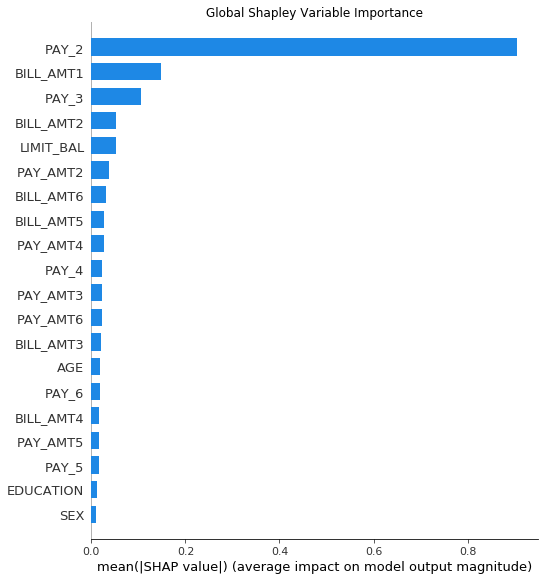

In [12]:
#Set all shapley values to their absolute value
shap_values_abs = np.absolute(shap_values[:,:,:-1])

#Plot mean absolute shapley across all classes for global shapley variable importance
plt.title("Global Shapley Variable Importance")
shap.summary_plot(shap_values_abs.mean(axis=1), test[xgb_model.feature_names], plot_type="bar", show=False)
plt.savefig('./images/global_shapley.png',bbox_inches='tight')
plt.close()

#To show in notebook
plt.title("Global Shapley Variable Importance")
shap.summary_plot(shap_values_abs.mean(axis=1), test[xgb_model.feature_names], plot_type="bar")

The global variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, `PAY_2` is by far the most important variable globally. As someone's most recent behavior is a very good indicator of future behavior, this checks out.

### Global Eli5/Tree Interpreter Variable Importance

In [13]:
eli5.show_weights(xgb_model)

Weight,Feature
0.3682,PAY_2
0.1204,BILL_AMT1
0.1001,PAY_3
0.0545,PAY_4
0.0509,BILL_AMT2
0.0359,PAY_6
0.0347,PAY_5
0.0265,BILL_AMT3
0.0209,BILL_AMT4
0.0205,LIMIT_BAL


### Display Shapley variable importance summary per `PAY_0` class outcome

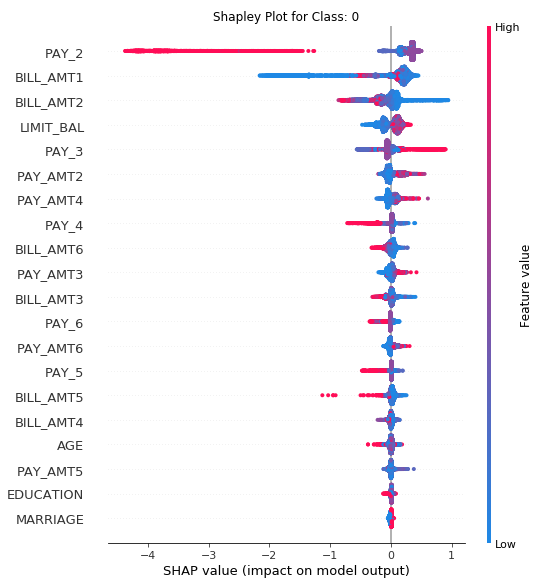

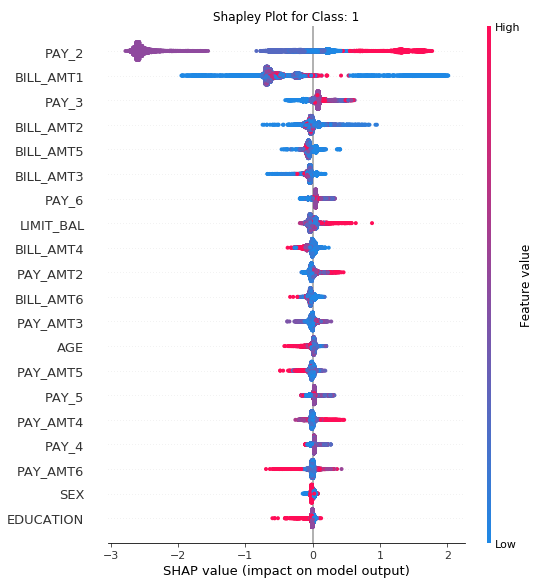

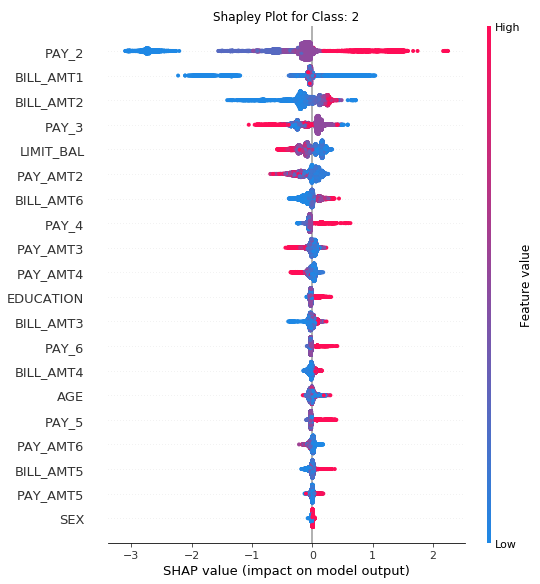

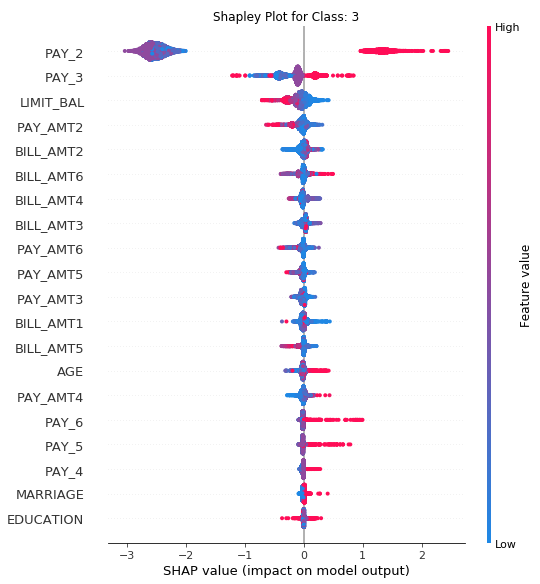

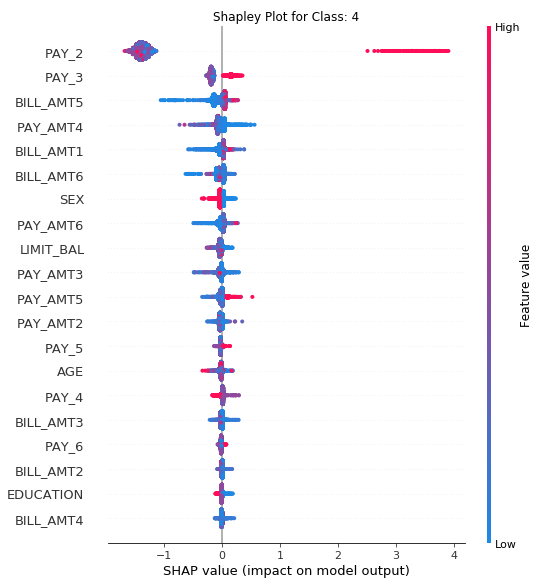

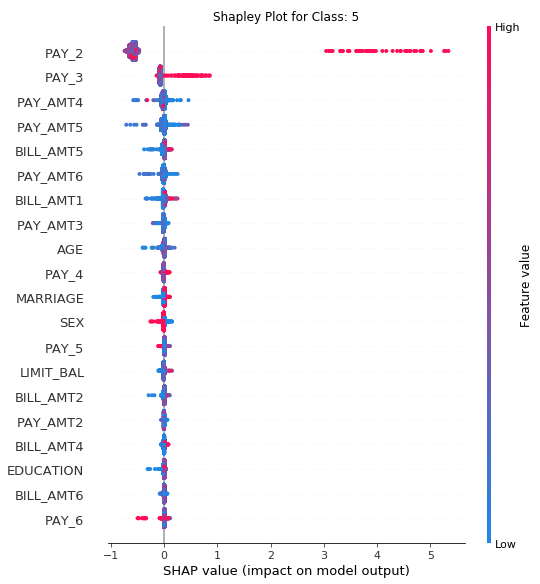

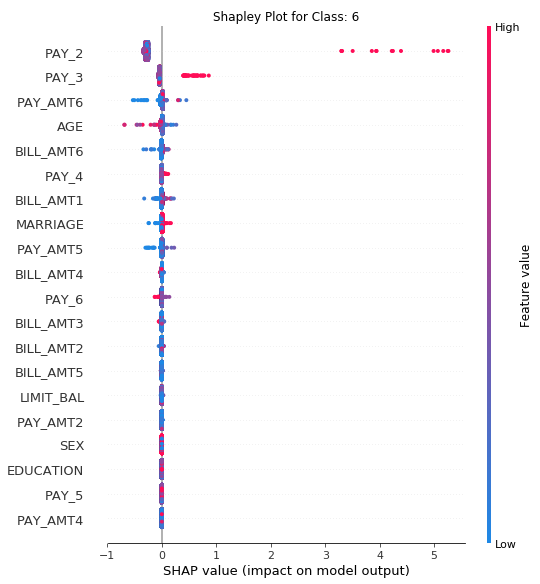

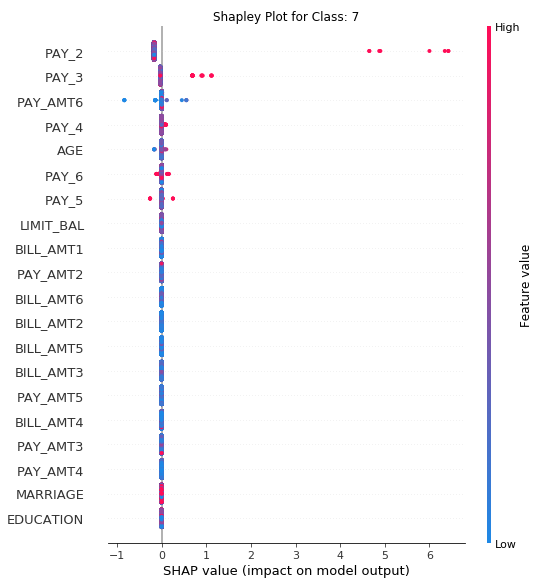

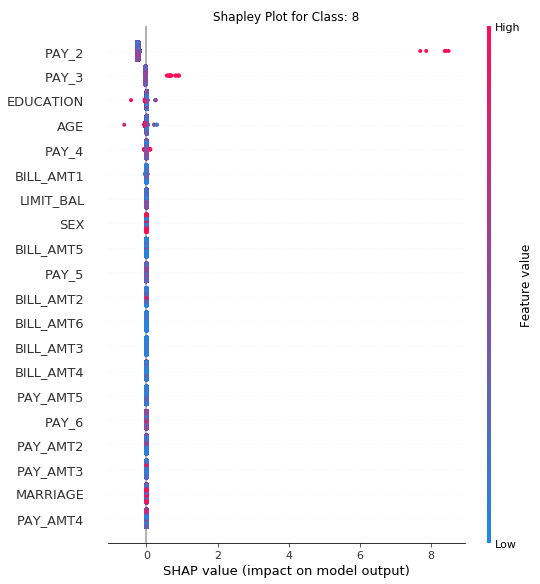

In [14]:
#Plot signed Shapley variable importance summary for a specific class (class 0, class 1, ..., class 8)
for i in range(0,9):
    plt.title("Shapley Plot for Class: " + str(i))
    shap.summary_plot(shap_values[:, i, :-1], test[xgb_model.feature_names], show=False)
    plt.savefig('./images/shapley_class_' + str(i) + ".png", bbox_inches='tight')
    plt.close()
    #To show in notebook
    plt.title("Shapley Plot for Class: " + str(i))
    shap.summary_plot(shap_values[:, i, :-1], test[xgb_model.feature_names])

The global variable importance ranking should be parsimonious with human domain knowledge and reasonable expectations. In this case, `PAY_2` is by far the most important variable per class in the general sense. As someone's most recent behavior is a very good indicator of future behavior, this checks out, again. 

In [15]:
#Predict on test set
preds = xgb_model.predict(dtest)

In [16]:
#Display predictions as a Pandas frame
#Each column represents a class outcome for PAY_0: 0, 1, 2, ..., 8.
pd.DataFrame(preds).head()

,0,1,2,3,4,5,6,7,8
0,0.251518,0.634122,0.089751,0.021119,0.000700,0.000698,0.000698,0.000698,0.000698
1,0.981166,0.001926,0.015851,0.000213,0.000169,0.000169,0.000169,0.000169,0.000169
2,0.994497,0.000931,0.003969,0.000160,0.000105,0.000084,0.000084,0.000084,0.000084
3,0.994529,0.001272,0.003596,0.000138,0.000105,0.000090,0.000090,0.000090,0.000090
4,0.987320,0.009606,0.002351,0.000138,0.000117,0.000117,0.000117,0.000117,0.000117


In [17]:
#Look at model accuracy
pred_prob = xgb_model.predict(dtest).reshape(test[y].shape[0], 9)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != test[y]) / test[y].shape[0]
print('Test error using softprob = {}'.format(error_rate))

Test error using softprob = 0.10956483322288492


In [18]:
#For each line we need to select that column 
#where the probability is the highest
best_preds = np.asarray([np.argmax(line) for line in preds])
best_preds

array([1, 0, 0, ..., 0, 3, 0])

In [19]:
#Get actual values of PAY_0 in test set
test_true = test["PAY_0"].values

In [20]:
#Look at confusion matrix
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test_true, best_preds)
cnf_matrix

array([[6734,  160,    8,    0,    0,    0,    0,    0,    0],
       [  93,  913,  168,    0,    0,    1,    0,    1,    1],
       [ 307,  132,  381,    7,    3,    2,    0,    0,    0],
       [   7,   37,   37,   21,    1,    0,    0,    0,    0],
       [   0,   16,    2,    0,    3,    0,    0,    0,    0],
       [   1,    3,    0,    0,    2,    3,    0,    0,    0],
       [   0,    1,    0,    0,    2,    0,    1,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    2,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    4]])

In [21]:
#Look at precision and F1 with micro and macro averaging
from sklearn.metrics import precision_score, f1_score

print("Macro Precision: %s" % str(precision_score(test_true, best_preds, average='macro')))
print("Micro Precision: %s" % str(precision_score(test_true, best_preds, average='micro')))

print("Macro F1: %s" % str(f1_score(test_true, best_preds, average='macro')))
print("Micro F1: %s" % str(f1_score(test_true, best_preds, average='micro')))

Macro Precision: 0.6994426291928022
Micro Precision: 0.8904351667771151
Macro F1: 0.5820296168696617
Micro F1: 0.8904351667771151


# Calculating partial dependence for a multinomial model
Partial dependence plots are used to view the global, average prediction behavior of a variable under the multinomial model. Multinomial partial dependence plots show the average prediction per class of the multinomial model as a function of specific values of an input variable of interest, indicating how the GBM predictions per class outcome change based on the values of the input variable of interest, while taking nonlinearity into consideration and averaging out the effects of all other input variables. Partial dependence plots enable increased transparency into the GBM's mechanisms and enable validation and debugging of the GBM by comparing a variable's average predictions per class across its domain to known standards and reasonable expectations. Partial dependence plots are described in greater detail in The Elements of Statistical Learning, section 10.13: https://web.stanford.edu/~hastie/ElemStatLearn/printings/ESLII_print12.pdf.

### Function for calculating multinomial partial dependence

In [22]:
def par_dep_multinomial(xs, frame, model, resolution=20, bins=None, num_classes=0):
    
    """ Creates Pandas DataFrame containing partial dependence for a 
        single variable.
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
        num_classes: Number of classes in outcome
    
    Returns:
        Pandas DataFrame containing partial dependence values per class.
        
    """
    
    #Turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    #Initialize empty Pandas DataFrame with correct column names
    class_name_columns = [0] * (num_classes + 1)
    class_name_columns[0] = xs
    for i in range(1, 10):
        class_name_columns[i] = 'partial_dependence_' + str(i-1)
    par_dep_frame = pd.DataFrame(columns=class_name_columns)
    
    #Cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    #Determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    #Calculate partial dependence  
    #by setting column of interest to constant 
    #and scoring the altered data and taking the mean of the predictions per class
    row_idx = 0 #Keep track of row index for proper assignment 
    #Per bin
    for j in bins:
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame)
        par_dep_i = pd.DataFrame(model.predict(dframe))
        #Per class
        for i in range(0, num_classes):
            par_dep_frame.loc[row_idx, xs] = j
            par_dep_j = par_dep_i[i].mean()
            par_dep_frame.loc[row_idx, 'partial_dependence_' + str(i)] = par_dep_j
        row_idx+=1 #Increment and go onto next row
        
    #Return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return par_dep_frame

### Calculate partial dependence for the most important input variable(s) in the GBM
`PAY_2` is the most important variable according to global Shapley variable importance.

In [23]:
pdp_PAY_2 = par_dep_multinomial(xs="PAY_2", frame=test[X], model=xgb_model, resolution=20, bins=None, num_classes=9)
pdp_PAY_2.head()

,PAY_2,partial_dependence_0,partial_dependence_1,partial_dependence_2,partial_dependence_3,partial_dependence_4,partial_dependence_5,partial_dependence_6,partial_dependence_7,partial_dependence_8
0,-2,0.901783,0.0934248,0.00313922,0.000356067,0.00026888,0.000257912,0.000256793,0.000256776,0.000256246
1,-1.5,0.897459,0.0773158,0.0236135,0.000345982,0.000262341,0.000251874,0.000250819,0.000250814,0.000250315
2,-1,0.897459,0.0773158,0.0236135,0.000345982,0.000262341,0.000251874,0.000250819,0.000250814,0.000250315
3,-0.5,0.921956,0.0402107,0.0360694,0.00037152,0.000286482,0.000277318,0.000276318,0.000276331,0.000275896
4,0,0.921956,0.0402107,0.0360694,0.00037152,0.000286482,0.000277318,0.000276318,0.000276331,0.000275896


# Plotting multinomial partial dependence
Plotting the partial dependence per class is a good way of getting a global view of the multinomial model in question. 

**Note: If the number of outcome classes > 10, then we would only take the top 10 most common classes by default.**

In [24]:
def plot_multinomial_pdp(pdp_data, xs):
    fig, ax = plt.subplots()
    for i in range(0, 9):
        pdp_data.plot(x=xs,y="partial_dependence_"+str(i), ax=ax)
    plt.title("Multinomial Partial Dependency Plot")
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig("./images/global_pdp.png", bbox_inches='tight')
    plt.show()
    plt.close()

### PDP for PAY_2 across all class outcomes for `PAY_0`
Some key outcomes to focus on are the probability of being in outcome `0` (no consumption, pay duly, use of revolving credit) and outcome `8` (8 month delay) as these two outcomes represent the "best" customer outcome and the "worst" customer outcome. 

For being in outcome `0` we can see a decrease in probability once `PAY_2` starts becoming > 0, which means the most recent payment is >=1 month delay. Conversely, we can see an increase in probability of being in outcome `8` once the most recent payment >6 month delay. These two observations make sense as they are reflective of the most recent behavior which is usually a good indicator of future behavior. 

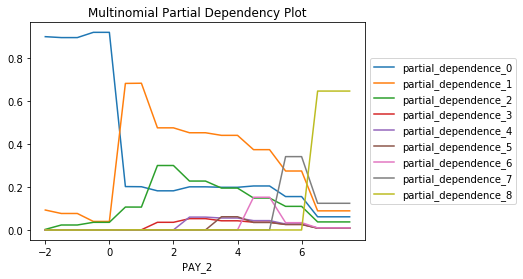

In [25]:
plot_multinomial_pdp(pdp_PAY_2, "PAY_2")

### Plotting partial dependence for a specific class outcome of interest

In [26]:
def plot_pdp_class_outcome(pdp_data, xs, class_category):
    fig, ax = plt.subplots()
    plt.title("Partial Dependency Plot for Outcome: " + str(class_category))
    pdp_data.plot(x=xs,y="partial_dependence_"+str(class_category), ax=ax)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.savefig("./images/pdp_class_" + str(class_category) + ".png", bbox_inches='tight')
    plt.show()
    plt.close()

### PDP for `PAY_2` and `PAY_0` outcome, `0` (`'no consumption', 'pay duly', 'use of revolving credit'`)

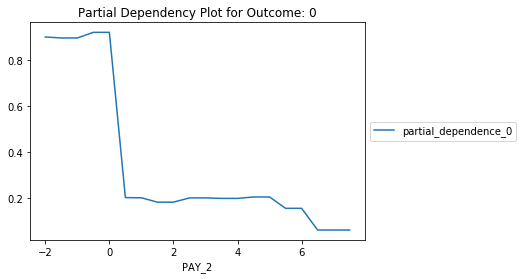

In [27]:
plot_pdp_class_outcome(pdp_PAY_2, "PAY_2", 0)

### PDP for `PAY_2` and  all `PAY_0`  outcomes

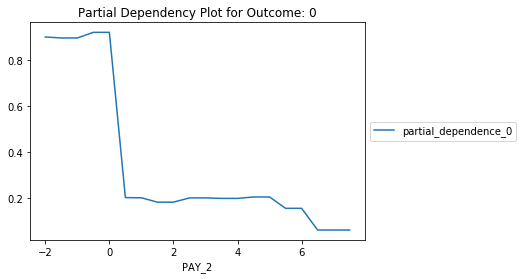

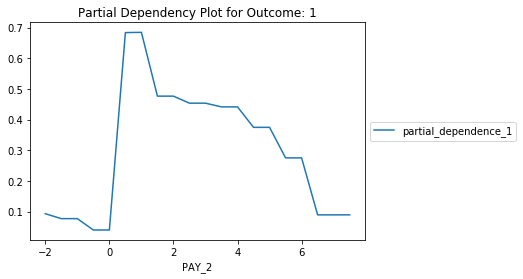

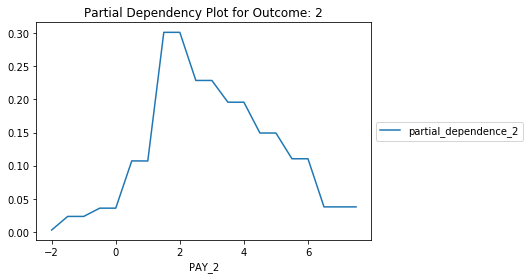

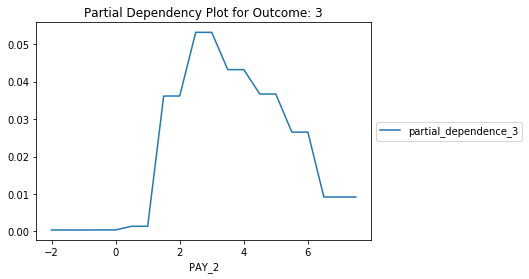

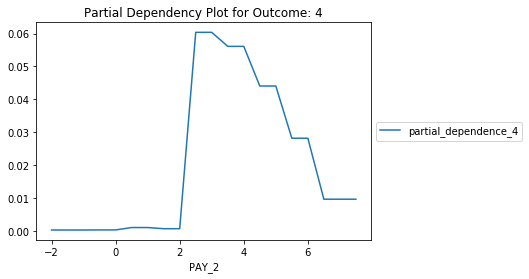

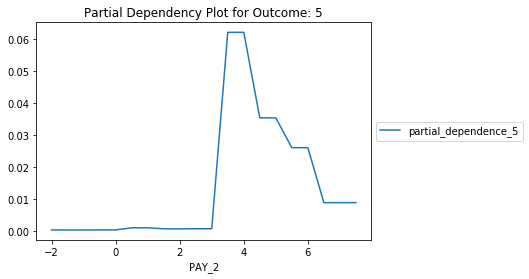

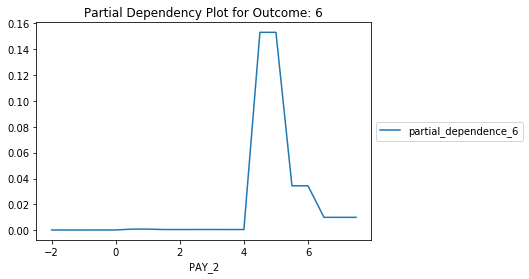

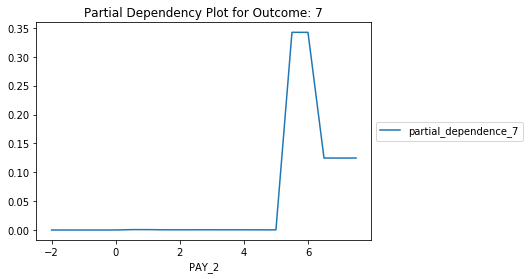

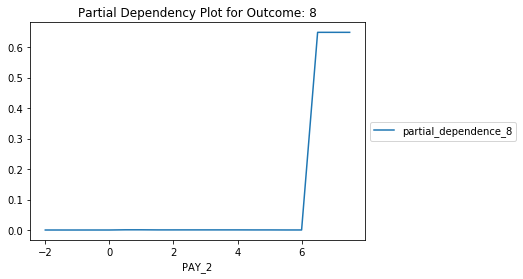

In [28]:
for i in range(0,9):
    plot_pdp_class_outcome(pdp_PAY_2, "PAY_2", i)

# Calculating Individual Conditional Expectation (ICE) for a multinomial model
Individual conditional expectation (ICE) plots, a newer and less well-known adaptation of partial dependence plots, can be used to create more localized explanations for a single observation of data using the same basic ideas as partial dependence plots. ICE is also a type of nonlinear sensitivity analysis in which the model predictions for a single observation are measured while a feature of interest is varied over its domain. ICE increases understanding and transparency by displaying the nonlinear behavior of the GBM. ICE also enhances trust, accountability, and fairness by enabling comparisons of nonlinear behavior to human domain knowledge and reasonable expectations. ICE, as a type of sensitivity analysis, can also engender trust when model behavior on simulated or extreme data points is acceptable. A detailed description of ICE is available in this arXiv preprint: https://arxiv.org/abs/1309.6392.

### Helper function for finding percentiles of predictions
ICE can be calculated for any row in the training or test data, but without intimate knowledge of a data source it can be difficult to know where to apply ICE. Calculating and analyzing ICE curves for every row of training and test data set can be overwhelming, even for the example credit card default dataset. One place to start with ICE is to calculate ICE curves at every decile of predicted probabilities in a dataset, giving an indication of local prediction behavior across the dataset. The function below finds and returns the row indices for the maximum, minimum, and deciles of one column in terms of another -- in this case, the model predictions for being in class 0 (`'no consumption', 'pay duly', 'use of revolving credit'`) and the row identifier (ID), respectively.

In [29]:
def get_percentile_dict(yhat, id_, frame):

    """ Returns the percentiles of a column, yhat, as the indices based on 
        another column id_.
    
    Args:
        yhat: Column in which to find percentiles.
        id_: Id column that stores indices for percentiles of yhat.
        frame: Pandas DataFrame containing yhat and id_. 
    
    Returns:
        Dictionary of percentile values and index column values.
    
    """
    
    #Create a copy of frame and sort it by yhat
    sort_df = frame.copy(deep=True)
    sort_df.sort_values(yhat, inplace=True)
    sort_df.reset_index(inplace=True)
    
    #Find top and bottom percentiles
    percentiles_dict = {}
    percentiles_dict[0] = sort_df.loc[0, id_]
    percentiles_dict[99] = sort_df.loc[sort_df.shape[0]-1, id_]

    #Find 10th-90th percentiles
    inc = sort_df.shape[0]//10
    for i in range(1, 10):
        percentiles_dict[i * 10] = sort_df.loc[i * inc,  id_]

    return percentiles_dict

### Find some percentiles of yhat for a particular `PAY_0` outcome in the test data
The values for ID that correspond to the maximum, minimum, and deciles of being in class 0 (`'no consumption', 'pay duly', 'use of revolving credit'`) are displayed below. ICE will be calculated for the rows of the test dataset associated with these ID values.

In [30]:
def get_percentiles_for_class(dtest, class_category):
    #Merge GBM predictions onto test data
    yhat_test = pd.concat([test.reset_index(drop=True), pd.DataFrame(xgb_model.predict(dtest)[:,class_category])], 
                          axis=1)
    yhat_test = yhat_test.rename(columns={0:'p_class_' + str(class_category)})

    #Find percentiles of predictions
    percentile_dict = get_percentile_dict('p_class_' + str(class_category), 'ID', yhat_test)

    #Display percentiles dictionary
    #ID values for rows
    #from lowest prediction 
    #to highest prediction
    return percentile_dict

In [31]:
percentile_dict = get_percentiles_for_class(dtest, 0)
percentile_dict

{0: 18868,
 99: 8478,
 10: 17951,
 20: 3946,
 30: 21634,
 40: 13424,
 50: 28437,
 60: 8944,
 70: 28946,
 80: 16794,
 90: 15189}

### Calculate ICE curve values for PAY_2 against a particular `PAY_0` outcome in the test data

In [32]:
def calc_ice_curves(pdp_data, xs, id_col, class_category, num_classes):
    """ Creates Pandas DataFrame containing partial dependence and ICE
    for a single variable
    
    Args:
        pdp_data: Data contain partial dependence for a specific variable
        xs: Variable for which to calculate partial dependence.
        id_col: Column name containing percentiles (ID for credit card dataset)
        class_category: Class outcome of interest (an int ranging from 0-num_classes)
        num_classes: Number of classes in outcome
    
    Returns:
        Pandas DataFrame containing partial dependence and ICE values for a specific class outcome.
        
    """
    #Retreive bins from original partial dependence calculation
    bins = list(pdp_data[xs])
    pdp_ice_data = pdp_data[[xs, "partial_dependence_" + str(class_category)]]
    #Fr each percentile in percentile_dict
    #create a new column in the par_dep frame 
    #representing the ICE curve for that percentile
    #and the variables of interest
    for i in sorted(percentile_dict.keys()):

        col_name = 'Percentile_' + str(i)

        # ICE curves for PAY_0 across percentiles at bins_PAY_0 intervals
        pdp_ice_data[col_name] = par_dep_multinomial(xs, 
                                                  test[test[id_col] == int(percentile_dict[i])][X],  
                                                  xgb_model, 
                                                  bins=bins,
                                                  num_classes=num_classes)['partial_dependence_'+str(class_category)]
    return pdp_ice_data

### Calculate ICE curve values for `PAY_2` against `PAY_0` outcome, `0` ('no consumption', 'pay duly', 'use of revolving credit')

In [33]:
pdp_PAY_2_class_zero = calc_ice_curves(pdp_PAY_2, "PAY_2", "ID", 0, 9)
pdp_PAY_2_class_zero.head()

,PAY_2,partial_dependence_0,Percentile_0,Percentile_10,Percentile_20,Percentile_30,Percentile_40,Percentile_50,Percentile_60,Percentile_70,Percentile_80,Percentile_90,Percentile_99
0,-2,0.901783,0.924018,0.959988,0.420056,0.889686,0.918172,0.972533,0.961088,0.973151,0.962122,0.958828,0.980227
1,-1.5,0.897459,0.916123,0.938744,0.520299,0.910584,0.909145,0.96483,0.954701,0.965109,0.965581,0.971557,0.993519
2,-1,0.897459,0.916123,0.938744,0.520299,0.910584,0.909145,0.96483,0.954701,0.965109,0.965581,0.971557,0.993519
3,-0.5,0.921956,0.985398,0.983032,0.635224,0.903991,0.931623,0.948541,0.963479,0.976861,0.981297,0.988665,0.997429
4,0,0.921956,0.985398,0.983032,0.635224,0.903991,0.931623,0.948541,0.963479,0.976861,0.981297,0.988665,0.997429


# Plotting partial dependence and ICE for particular `PAY_0` outcome

In [34]:
def plot_par_dep_ICE(xs, par_dep_frame, class_index, colormap, style):

    
    """ Plots ICE overlayed onto partial dependence for a single variable.
    
    Args: 
        xs: Name of variable for which to plot ICE and partial dependence.
        par_dep_frame: Name of Pandas DataFrame containing ICE and partial
                       dependence values.
        class_index: Class outcome of interest. XGBoost see's this as a value from 0-N where N is number of classes
        colormap : Colormap to select colors from. If string, load colormap with that name from matplotlib.
        style : matplotlib line style per column
    
    """
    
    #Initialize figure and axis
    fig, ax = plt.subplots()
    
    #Plot ICE curves
    par_dep_frame.drop('partial_dependence_' + str(class_index), axis=1).plot(x=xs, 
                                                                 colormap=colormap,
                                                                 ax=ax)

    #Overlay partial dependence, annotate plot
    par_dep_frame.plot(title='Partial Dependence and ICE for ' + str(xs) 
                              + ' with class ' + str(class_index) + ' as an outcome',
                       x=xs, 
                       y='partial_dependence_' + str(class_index),
                       style=style, 
                       linewidth=6, 
                       ax=ax,
                       colormap=colormap)

    #Add legend
    _ = plt.legend(bbox_to_anchor=(1.05, 0),
                   loc=3, 
                   borderaxespad=0.)
    
    plt.savefig("./images/pdp_ice_class_simulated" + str(class_index) + ".png", bbox_inches='tight')
    plt.show()
    plt.close()

### Plot PDP & ICE curves for `PAY_2` against being in `PAY_0` outcome, `0` ('no consumption', 'pay duly', 'use of revolving credit')
The main behavior we can see across all deciles is a drop in probability of being in outcome `0` once the value of `PAY_2` > 0, which indicates having missing payments in the most recent month drives down the chances of being in outcome `0`.

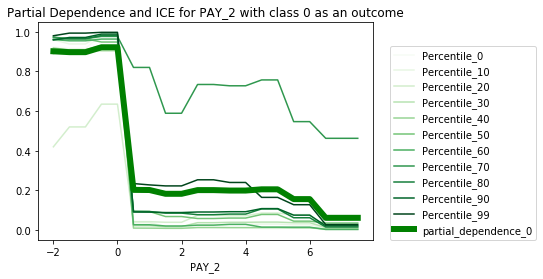

In [35]:
plot_par_dep_ICE('PAY_2', pdp_PAY_2_class_zero, 0, "Greens", "g-")

### Plot PDP and ICE curves for PAY_2 against every class outcome in PAY_0

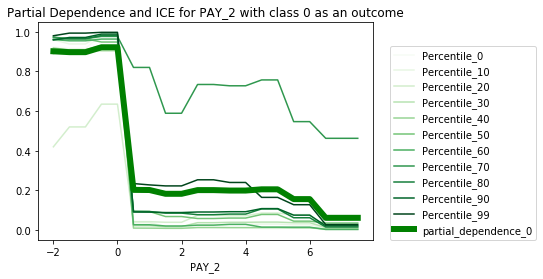

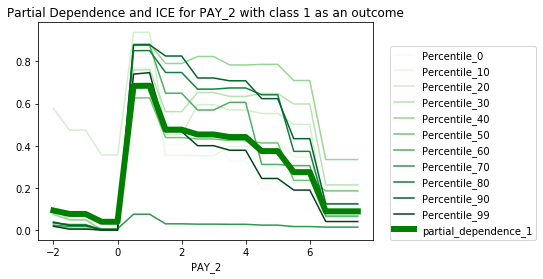

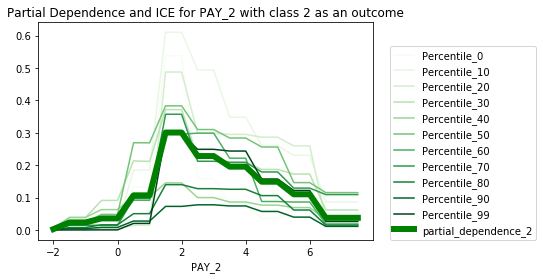

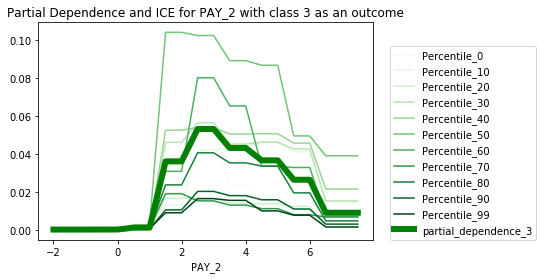

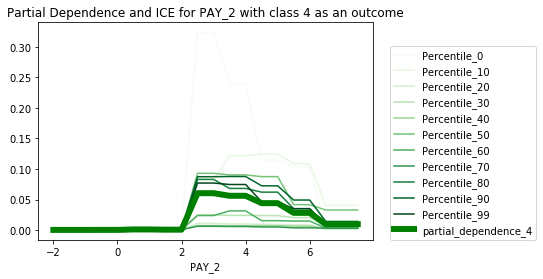

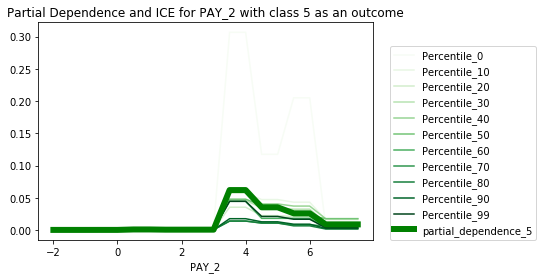

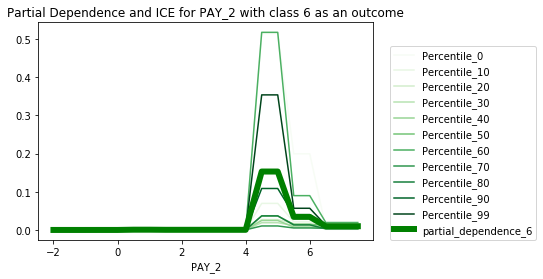

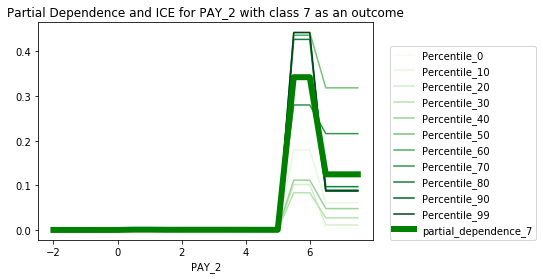

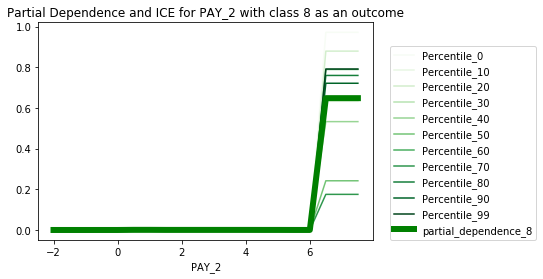

In [36]:
for i in range(0, 9):
    plot_par_dep_ICE('PAY_2', calc_ice_curves(pdp_PAY_2, "PAY_2", "ID", i, 9), i, "Greens", "g-")

# Generate reason codes using the Shapley method
Now that global behavior of the GBM has been verified and compared against domain knowledge and reasonable expectations, a method called Shapley explanations will be used to calculate the local variable importance for any one prediction: http://papers.nips.cc/paper/7062-a-unified-approach-to-interpreting-model-predictions. Shapley explanations are the only possible consistent local variable importance values. (Here consistency means that if a variable is more important than another variable in a given prediction, the more important variable's Shapley value will not be smaller in magnitude than the less important variable's Shapley value.) Very crucially Shapley values also always sum to the actual prediction of the XGBoost model. When used in a model-specific context for decision tree models, Shapley values are likely the most accurate known local variable importance method available today. In this notebook, XGBoost itself is used to create Shapley values with the pred_contribs parameter to predict(), but the shap package is also available for other types of models: https://github.com/slundberg/shap.

The numeric Shapley values in each column are an estimate of how much each variable contributed to each prediction. Shapley contributions can indicate how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are related to "local feature importance", "reason codes", or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the U.S. must provide reasons for automatically rejecting a credit application. Reason codes can be easily extracted from Shapley local variable contribution values by ranking the variables that played the largest role in any given decision.

To find the index corresponding to a particular row of interest later, the index of the test DataFrame is reset to begin at 0 and increase sequentially. Without resetting the index, the test DataFrame row indices still correspond to the original raw data from which the test set was sampled.

In [37]:
test.reset_index(drop=True, inplace=True)

### Function to plot Shapley values per class for a particular row at a certain decile

In [38]:
def plot_shapley_row(decile, row, class_index=None):
    if class_index is None:
        for i in range(0,9):
            s_df = pd.DataFrame(shap_values[row.index[0], i][:-1].reshape(21, 1), columns=['Reason Codes'], index=X)
            s_df.sort_values(by='Reason Codes', inplace=True)

            _ = s_df.plot(kind='bar', 
                              title='Reason Codes for Riskiest Customer Being in Class: ' + str(i) + '\n', 
                              legend=False)
            plt.savefig("./images/shapley_" + str(decile) + "_" + str(i) + ".png", bbox_inches='tight')
            plt.show()
            plt.close()
    else:
        s_df = pd.DataFrame(shap_values[row.index[0], class_index][:-1].reshape(21, 1), columns=['Reason Codes'], index=X)
        s_df.sort_values(by='Reason Codes', inplace=True)

        _ = s_df.plot(kind='bar', 
                  title='Reason Codes for Model Prediction: ' + str(class_index) + '\n', 
                  legend=False)
        plt.savefig("./images/shapley_" + str(decile) + "_" + str(class_index) + ".png", bbox_inches='tight')
        plt.show()
        plt.close()

### Utility function that displays the TreeInterpreter results at the chosen decile

In [39]:
def eli5_dd(row, model):
    eli5_df = eli5.explain_prediction_df(model, row[X].iloc[0]).sort_values(by='weight', ascending=True)
    _ = eli5_df[['feature', 'weight']].plot(kind='bar', title='Approximate Local Contributions', x='feature', legend=False)
    return eli5.explain_prediction_xgboost(model, row[X].iloc[0])

### Utility function that displays the LIME result at the choosen decile

In [40]:
explainer = LIMEExplainer(training_frame=test, X=X, model=xgb_model, multinomial=True)
def lime(row):
    explainer.explain(row.index[0])

### Select riskiest customer in test data
One person who might be of immediate interest is the least likely to be in categorical level `0('no consumption', 'pay duly', 'use of revolving credit')` for the target variable, `PAY_0` in the test data. This customer's row will be selected and local variable importance for the corresponding prediction will be analyzed.

In [41]:
decile = 0
row = test[test['ID'] == percentile_dict[decile]]

### Local Eli5/Tree Interpreter Variable Importance

Explanation(estimator='<xgboost.core.Booster object at 0x11b6613c8>', description='\nFeatures with largest coefficients per class.\n\nFeature weights are calculated by following decision paths in trees\nof an ensemble. Each leaf has an output score, and expected scores can also be\nassigned to parent nodes. Contribution of one feature on the decision path\nis how much expected score changes from parent to child. Weights of all \nfeatures sum to the output score of the estimator.\n\nCaveats:\n1. Feature weights just show if the feature contributed positively or\n   negatively to the final score, and does show how increasing or decreasing\n   the feature value will change the prediction.\n2. In some cases, feature weight can be close to zero for an important feature.\n   For example, in a single tree that computes XOR function, the feature at the\n   top of the tree will have zero weight because expected scores for both\n   branches are equal, so decision at the top feature does not change the\n   expected score. For an ensemble predicting XOR functions it might not be\n   a problem, but it is not reliable if most trees happen to choose the same\n   feature at the top.\n', error=None, method='decision paths', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='<BIAS>', weight=2.8307480382658223, std=None, value=1.0), FeatureWeight(feature='PAY_AMT5', weight=0.13517198921896798, std=None, value=6000.0), FeatureWeight(feature='LIMIT_BAL', weight=0.12589893052758605, std=None, value=180000.0), FeatureWeight(feature='BILL_AMT6', weight=0.11808165050662284, std=None, value=184009.0), FeatureWeight(feature='BILL_AMT5', weight=0.06721812188989644, std=None, value=181137.0), FeatureWeight(feature='SEX', weight=0.02360918650477134, std=None, value=2.0), FeatureWeight(feature='MARRIAGE', weight=0.021294384876536804, std=None, value=2.0), FeatureWeight(feature='BILL_AMT4', weight=0.006032473365995354, std=None, value=185559.0)], neg=[FeatureWeight(feature='PAY_2', weight=-2.5450717350222, std=None, value=7.0), FeatureWeight(feature='BILL_AMT2', weight=-1.2301563797224229, std=None, value=194309.0), FeatureWeight(feature='BILL_AMT1', weight=-0.6833237061096838, std=None, value=197231.0), FeatureWeight(feature='BILL_AMT3', weight=-0.342392707666715, std=None, value=189981.0), FeatureWeight(feature='PAY_4', weight=-0.3035815702615498, std=None, value=5.0), FeatureWeight(feature='PAY_AMT3', weight=-0.19890141880656736, std=None, value=0.0), FeatureWeight(feature='PAY_3', weight=-0.1753519238755071, std=None, value=6.0), FeatureWeight(feature='PAY_AMT6', weight=-0.11212110643749938, std=None, value=0.0), FeatureWeight(feature='PAY_AMT2', weight=-0.08237833155927955, std=None, value=0.0), FeatureWeight(feature='PAY_6', weight=-0.07490364910607278, std=None, value=3.0), FeatureWeight(feature='AGE', weight=-0.07043162806376264, std=None, value=28.0), FeatureWeight(feature='PAY_AMT4', weight=-0.04370810795299218, std=None, value=0.0), FeatureWeight(feature='PAY_5', weight=-0.03397266016387218, std=None, value=4.0), FeatureWeight(feature='EDUCATION', weight=-0.001849358366419555, std=None, value=2.0)], pos_remaining=0, neg_remaining=0), proba=0.00034480143, score=-2.57008950795835, weighted_spans=None), TargetExplanation(target=1, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='PAY_2', weight=1.2764990321514136, std=None, value=7.0), FeatureWeight(feature='<BIAS>', weight=0.30385764343564625, std=None, value=1.0), FeatureWeight(feature='AGE', weight=0.08701978961238492, std=None, value=28.0), FeatureWeight(feature='PAY_AMT3', weight=0.06034114255948955, std=None, value=0.0), FeatureWeight(feature='PAY_AMT6', weight=0.027976003463542374, std=None, value=0.0), FeatureWeight(feature='LIMIT_BAL', weight=0.012317920612667255, std=None, value=180000.0), FeatureWeight(feature='MARRIAGE', weight=0.011497364074384363, std=None, value=2.0), FeatureWeight(feature='BILL_AMT6', weight=0.

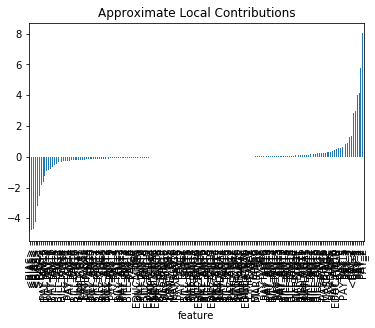

In [42]:
eli5_dd(row, xgb_model)

### LIME

Row:

      LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_2  PAY_3  PAY_4  PAY_5  \
5736     180000    2          2         2   28      7      6      5      4   

      PAY_6  BILL_AMT1  BILL_AMT2  BILL_AMT3  BILL_AMT4  BILL_AMT5  BILL_AMT6  \
5736      3     197231     194309     189981     185559     181137     184009   

      PAY_AMT2  PAY_AMT3  PAY_AMT4  PAY_AMT5  PAY_AMT6  
5736         0         0         0      6000         0  


Multinomial Model Prediction:

          0         1        2         3         4        5         6  \
0  0.000345  0.008913  0.00178  0.000688  0.002977  0.00589  0.005728   

          7         8  
0  0.002088  0.971591  


Local GLM Prediction: 0.65
Local GLM R-square: 0.16
Local GLM Intercept: 0.38

Approximate Local Contributions:
        Input  Local Contribution
0    PAY_AMT5            0.001099
1   BILL_AMT3            0.009459
2   BILL_AMT4            0.009529
3   BILL_AMT5            0.009733
4   BILL_AMT1            0.009886
5   BILL_AMT6 

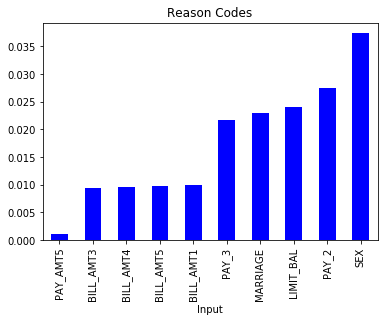

In [43]:
lime(row)

In [44]:
row.index[0]

5736

### Display Local Shapley variable importance summary for riskiest customer

#### A good way to look at multinomial Shapley variable importance involves getting the mean absolute Shapley value across all classes.

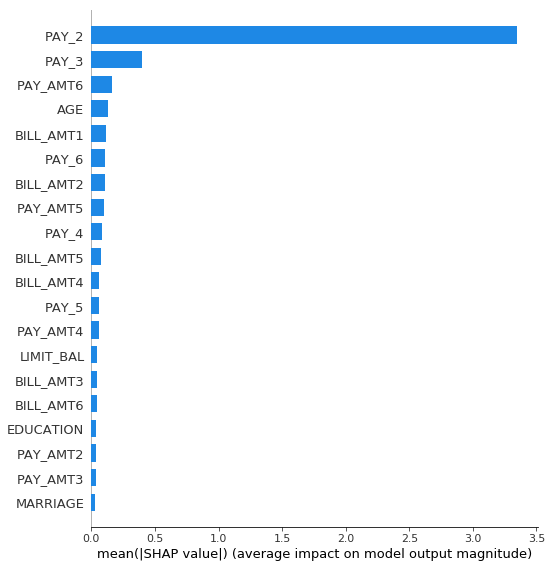

In [45]:
#Set all shapley values to their absolute value
shap_values_abs_row = np.absolute(shap_values[row.index[0],:,:-1])

#Plot mean absolute shapley across all classes for local shapley variable importance
plt.title("Local Shapley Variable Importance for Riskiest Customer")
shap.summary_plot(shap_values_abs_row, test[xgb_model.feature_names], plot_type="bar", show=False)
plt.savefig('./images/local_shapley_riskiest_customer.png',bbox_inches='tight')
plt.close()

#To show in notebook
shap.summary_plot(shap_values_abs_row, test[xgb_model.feature_names], plot_type="bar", show=False)

### Local Shapley variable importance per PAY_0 outcome for the riskiest customer

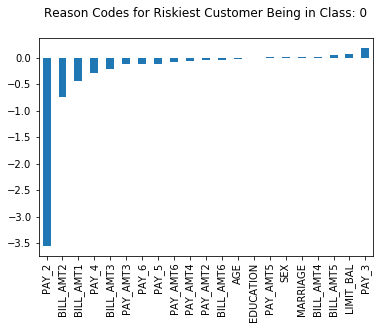

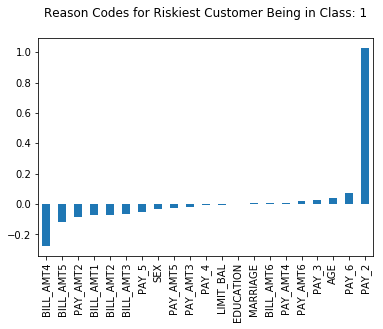

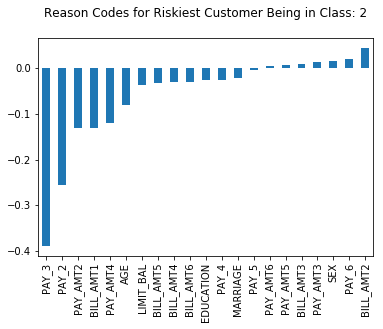

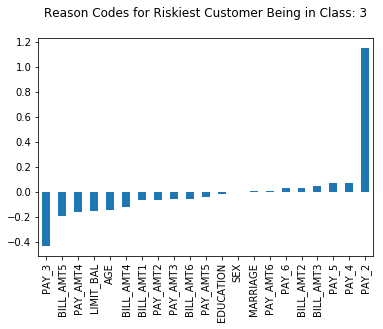

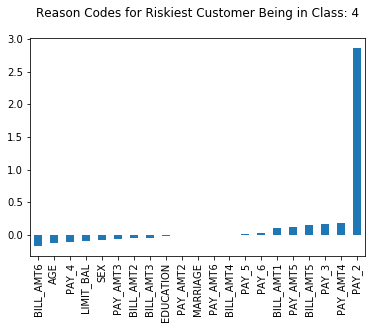

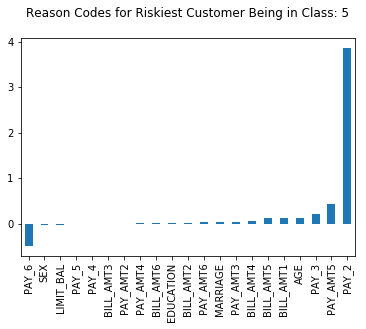

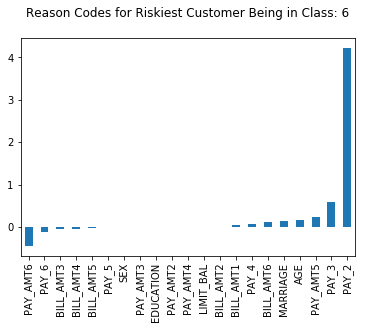

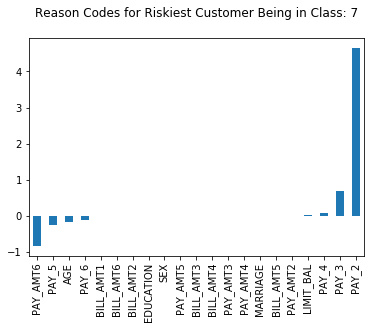

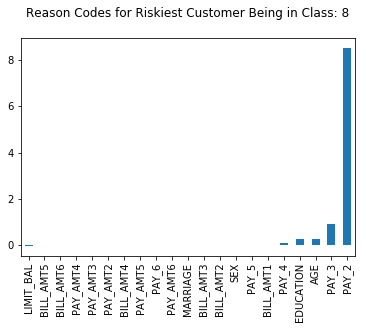

In [46]:
plot_shapley_row(decile, row)

### Function to get model predictions for minority class and majority class based on predicted probability

In [47]:
def get_pred(row, X):
    #Double check what the model actually predicted for this row
    row_pred = xgb_model.predict(xgb.DMatrix(row[X]))
    print("Predicted class probabilies: %s" % str(row_pred[0]))
    print("Smallest class probability based on model prediction: %s" % str(np.asarray([np.argmin(line) for line in row_pred])[0]))
    print("Highest class probability based on model prediction: %s" % str(np.asarray([np.argmax(line) for line in row_pred])[0]))

### What class does the model predict the riskiest customer to be in?

In [48]:
get_pred(row, X)

Predicted class probabilies: [3.4480143e-04 8.9130672e-03 1.7799124e-03 6.8822480e-04 2.9769146e-03
 5.8899196e-03 5.7280548e-03 2.0879088e-03 9.7159123e-01]
Smallest class probability based on model prediction: 0
Highest class probability based on model prediction: 8


### Shapley reason codes for model prediction of riskiest customer

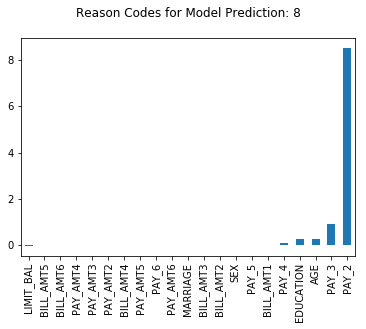

In [49]:
plot_shapley_row(0, row, 8)

For the customer in the test dataset that the GBM predicts as most likely to be in outcome `8` (8 month delay), the most important input variables seems to be `PAY_2` by a large margin followed by `PAY_3`

### Display customer in question
The local contributions for this customer appear reasonable, especially when considering her payment information. Her most recent payment was 7 months late and the one previous 6 months late, which pushed her probability of being in class outcome `8` (8 month delay) very high. 

In [50]:
row #Helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
5736,18868,180000,2,2,2,28,8,7,6,5,4,3,197231,194309,189981,185559,181137,184009,0,0,0,0,6000,0,1


### Select LEAST riskiest customer in test data
Another person who might be of immediate interest is the most likely to be in categorical level 0('no consumption', 'pay duly', 'use of revolving credit') for the target variable, PAY_0 in the test data. This customer's row will be selected and local variable importance for the corresponding prediction will be analyzed.

In [51]:
decile = 99
row = test[test['ID'] == percentile_dict[decile]]

### Local Eli5/Tree Interpreter Variable Importance

In [ ]:
eli5_dd(row, xgb_model)

### LIME

In [ ]:
lime(row)

### Display Local Shapley variable importance summary for LEAST riskiest customer¶

#### A good way to look at multinomial Shapley variable importance involves getting the mean absolute Shapley value across all classes.

In [ ]:
#Set all shapley values to their absolute value
shap_values_abs_row = np.absolute(shap_values[row.index[0],:,:-1])

#Plot mean absolute shapley across all classes for local shapley variable importance
plt.title("Local Shapley Variable Importance for Least Riskiest Customer")
shap.summary_plot(shap_values_abs_row, test[xgb_model.feature_names], plot_type="bar", show=False)
plt.savefig('./images/local_shapley_least_riskiest_customer.png',bbox_inches='tight')
plt.close()

#To show in notebook
shap.summary_plot(shap_values_abs_row, test[xgb_model.feature_names], plot_type="bar", show=False)

### Local Shapley variable importance per `PAY_0` outcome for LEAST riskiest customer

In [ ]:
plot_shapley_row(decile, row)

### What class does the model predict the LEAST riskiest customer to be in?

In [ ]:
get_pred(row, X)

### Shapley Reason codes for model prediction of LEAST riskiest customer

In [ ]:
plot_shapley_row(decile, row, 0)

For the customer in the test dataset that the GBM predicts as most likely to be in outcome `0` ('no consumption', 'pay duly', 'use of revolving credit'), the top 4 most important input variables seems to be `PAY_2`, `BILL_AMT1`, `PAY_AMT2`, and `LIMIT_BAL`.

### Display customer in question
The local contributions for this customer appear reasonable, especially when considering her payment information. Her most recent payment (`PAY_2`) was paid duly which we have seen carries a high importance both globally and locally, `BILL_AMT1` (34785) is small compared to the very high `LIMIT_BAL` (430,000), and `PAY_AMT2` is 18518 which matches the amount for `BILL_AMT3` indicating the statement from July, 2005 was fully paid off in August, 2005

In [ ]:
row #Helps understand reason codes

### Write out predictions, predicted class, and original columns to disk

In [ ]:
preds = pd.DataFrame(xgb_model.predict(dtest))
preds.columns = ['prob_PAY_0_class' + str(col) for col in preds.columns]
test_with_preds = pd.concat([test.reset_index(drop=True), preds], axis=1)
test_with_preds = test_with_preds.drop(['PAY_AMT1', 'ID', 'default payment next month'], axis=1)
test_with_preds["pred_PAY_0"] = test_with_preds[preds.columns].idxmax(axis=1).str.split('_').str.get(3)
test_with_preds.head()

In [ ]:
#Write train, test, and test with preds to csv
test_with_preds.to_csv("./output/credit_mult_preds.csv", index=False)
train.to_csv("../data/train.csv", index=False)
test.to_csv("../data/test.csv", index=False)